<a href="https://colab.research.google.com/github/v4chelsea/AdaIN_Style_Transfer/blob/main/AdaINStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdaIN Style Transfer 순서

1. Content, Style 이미지 준비
2. Pretrained VGG Encoder로 각 Image Feature추출
3. 추출된 Feature을 AdaIN으로 연산
4. 연산된 AdaIN을 Decoder를 통해 output 생성
5. 생성된 Output을 통해 Content & Style Loss 연산
6. Decoder 학습 진행
7. 학습 완료시까지 반복

In [2]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython import display
from tqdm.notebook import tqdm

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import os, PIL, time

In [4]:
# 데이터 찾기
def find_path(path):
    file_list = os.listdir(path)
    return file_list

# 이미지 전처리 => Normalization
def png_to_np(file_name, read_type='rgb', resize=True, shape=(256, 256)):
    if read_type == "rgb":
      image = PIL.Image.open(file_name) # (256, 256, 3)
    elif read_type == "gray":
      image = PIL.Image.open(file_name).convert("L") # (256, 256, 1)

    if resize:
      image = image.resize(shape)

    return (np.array(image).astype(np.uint8))

In [5]:
# 필요한 Image 형태 = [batch, width, height, channel]
path = 'drive/MyDrive/dataset/StyleTransfer'
file_list = find_path(path)

# path에 들어있는 이미지 가져오기
images = []
for idx, file in tqdm(enumerate(file_list), desc="loading dataset"):
  file_name = path + '/' + file
  image = png_to_np(file_name)
  images.append(image)

np_images = np.array(images)

loading dataset: 0it [00:00, ?it/s]

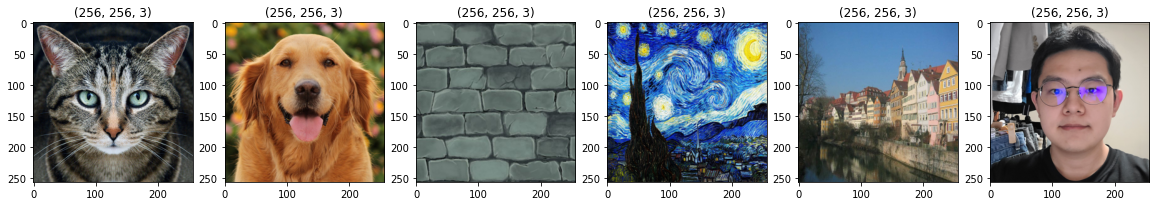

In [6]:
# Image를 띄워주는 영역
fig = plt.figure(figsize=(20, 8))
for idx, image in enumerate(np_images):
  plt.subplot(1, 6, idx + 1)
  plt.title(image.shape)
  plt.imshow(image)
plt.show()

In [8]:
# convert, style image 설정
c_image = images[5]
s_image = images[3]

# numpy to tensor
c_image = tf.convert_to_tensor(c_image, dtype=tf.float32)
s_image = tf.convert_to_tensor(s_image, dtype=tf.float32)

# Batch 차원 추가
c_image = c_image[tf.newaxis, ...]
s_image = s_image[tf.newaxis, ...]

In [ ]:
class AdaINStyleTransfer(tf.keras.models.Model):
  def __init__(self):
      super(AdaINStyleTransfer, self).__init__()
      self.axes = [1, 2]
      self.epsilon = 1e-5
      self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
      self.encoder = encoder()
      self.decoder = decoder()

  def adaIN(self, style, content):
    '''
    style = style image
    content = content image
    eplison = little number to prevent multiple with 0
    tf.nn.moments => calculate mean, var & std => sqrt(var + epsilon)
    '''
    c_mean, c_var = tf.nn.moments(content, axes=self.axes, keepdims=True)
    s_mean, s_var = tf.nn.moments(style, axes=self.axes, keepdims=True)
    c_std, s_std = tf.sqrt(c_var + self.epsilon), tf.sqrt(s_var + self.epsilon)
    
    t = s_std * (content - c_mean) / c_std + s_mean
    return t

  # encoder, decoder 구조 변경
  def encoder(self):
    a_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

    a_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_input_img)   # 128 -> 64 
    a_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_encoder1)    # 64 -> 32

    a_flatten = flatten()(a_encoder2)
    a_dense1 = dense(10, activation=leakyrelu)(a_flatten)
    a_dense2 = dense(int(image_size/4) * int(image_size/4) * 64, activation=leakyrelu)(a_dense1)

    a_reshape = reshape(target_shape=(int(image_size/4), int(image_size/4), 64), input_shape=(a_dense2,))(a_dense2)

    a_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_reshape)
    a_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(a_decoder1)

    encoder = tf.keras.Model(inputs=a_input_img, outputs=a_decoder2, name='Encoder')

    return encoder

  def decoder(self):
    a_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

    a_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_input_img)   # 128 -> 64 
    a_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_encoder1)    # 64 -> 32

    a_flatten = flatten()(a_encoder2)
    a_dense1 = dense(10, activation=leakyrelu)(a_flatten)
    a_dense2 = dense(int(image_size/4) * int(image_size/4) * 64, activation=leakyrelu)(a_dense1)

    a_reshape = reshape(target_shape=(int(image_size/4), int(image_size/4), 64), input_shape=(a_dense2,))(a_dense2)

    a_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_reshape)
    a_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(a_decoder1)

    decoder = tf.keras.Model(inputs=a_input_img, outputs=a_decoder2, name='Decoder')

    return decoder

  def calc_losses(self, style, t, output):
    c_mse = tf.keras.losses.MeanSquaredError()
    s_mse_1 = tf.keras.losses.MeanSquaredError()
    s_mse_2 = tf.keras.losses.MeanSquaredError()

    content_loss = c_mse(output, t)

    o_mean, o_var = tf.nn.moments(output, axes=self.axes, keepdims=True)
    s_mean, s_var = tf.nn.moments(style, axes=self.axes, keepdims=True)
    o_std, s_std = tf.sqrt(o_var + self.epsilon), tf.sqrt(s_var + self.epsilon)

    style_loss = s_mse_1(o_mean, s_mean) + s_mse_2(o_std, s_std)

    return content_loss + style_loss

    #style_loss_weight = xxx
    #return content_loss + style_loss * style_loss_weight
    

  def call(self, style, content):
    f_style = self.encoder(style)
    f_content = self.encoder(content)

    t = adaIN(f_style, f_content)

    # first output
    output = self.decoder(t)

    # calculate Loss
    f_output = self.encoder(output)

    total_loss = calc_losses(style, t, output)

    return total_loss